## Analyzing Target’s E-commerce Landscape: Sales, Trends, and Customer Insights


In [47]:

# import neccessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import mysql.connector
import pymysql
import warnings
warnings.filterwarnings('ignore')


In [48]:

# Establishing a connection to the MySQL database
db = pymysql.connect(
    host='localhost',
    user='root',
    password='Rafi@mysql123',
    database='commerce'
)
cur = db.cursor()
cur

In [49]:
tables = cur.execute('SHOW TABLES')
for table in cur:
    print(table)

('customers',)
('geolocation',)
('order_items',)
('orders',)
('payments',)
('products',)
('sellers',)


 ### *List all unique cities where customers are located.*

In [50]:
query = ''' SELECT DISTINCT customer_city 
            FROM customers'''

cur.execute(query)

data = cur.fetchall()
pd.DataFrame(data, columns = ['City'])


,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### *Count the number of orders placed in 2017*

In [51]:
query = ''' SELECT COUNT(order_ID) 
            FROM orders 
            WHERE YEAR(order_purchase_timestamp) = 2017 '''

cur.execute(query)

data = cur.fetchall()
print('Total orders placed in 2017 is: ', data[0][0])


Total orders placed in 2017 is:  45101


### *Find the total sales per category.*

In [52]:
query = ''' SELECT UPPER(`Product category`), SUM(payment_value) 
            FROM Products p JOIN order_items ot
            ON p.product_id = ot.product_id
            JOIN payments pm
            ON ot.order_id = pm.order_ID
            GROUP BY `Product category`
            '''

cur.execute(query)

data = cur.fetchall()
pd.set_option('display.float_format', '{:.2f}'.format)
pd.DataFrame(data, columns = ['Product_category', 'Sales'])


,Product_category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


### *Calculate the percentage of orders that were paid in installments.*

In [53]:
query = ''' SELECT (SUM( 
                       CASE WHEN 
                                payment_installments > 1 THEN 1 ELSE 0 END) / COUNT(order_id)) * 100
            FROM Payments'''


cur.execute(query)

data = cur.fetchall()

print('Percentage of orders that were paid in installments', data[0][0])


Percentage of orders that were paid in installments 49.4176


### *Count the number of customers from each state.*

In [54]:
query = ''' SELECT customer_state, COUNT(customer_id)
            FROM Customers
            GROUP BY customer_state'''

cur.execute(query)

data = cur.fetchall()
df =  pd.DataFrame(data, columns = ['State', 'Number of customers'])
df


,State,Number of customers
0,SP,41746
1,SC,3637
2,MG,11635
3,PR,5045
4,RJ,12852
5,RS,5466
6,PA,975
7,GO,2020
8,ES,2033
9,BA,3380


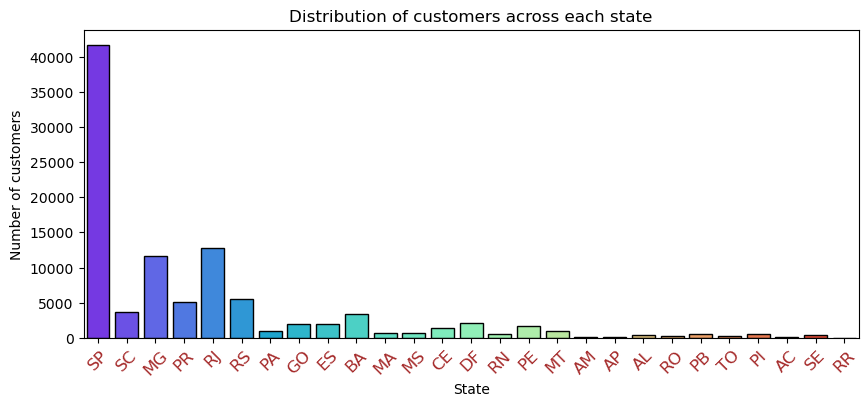

In [55]:
# visualization
plt.figure(figsize = (10,4))
sns.barplot(x = 'State', y = 'Number of customers', data = df, palette = 'rainbow', edgecolor = 'black')
plt.title('Distribution of customers across each state')
plt.xticks(rotation = 45, size = 12, color = 'brown')
plt.show()


### *Calculate the number of orders per month in 2018.*

In [56]:
query = ''' SELECT MONTHNAME(order_purchase_timestamp), COUNT(order_id) 
            FROM Orders
            WHERE YEAR(order_purchase_timestamp) = 2018
            GROUP BY MONTHNAME(order_purchase_timestamp)
            '''

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Month', 'Number of orders'])
df


,Month,Number of orders
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211
5,January,7269
6,May,6873
7,April,6939
8,September,16
9,October,4


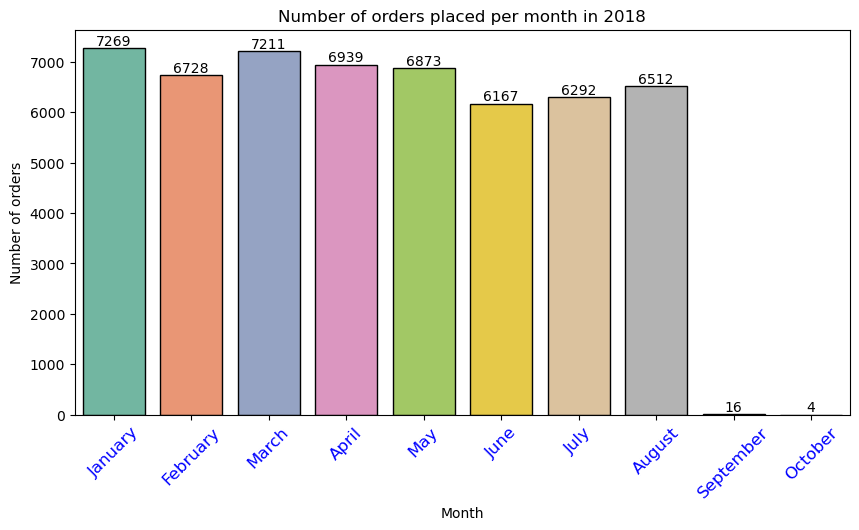

In [57]:
# visualization
o = ['January', 'February', 'March', "April", 'May', "June", 'July', 'August', 'September', 'October']
plt.figure(figsize = (10,5))
ax = sns.barplot(x = 'Month', y = 'Number of orders', data = df, palette = 'Set2', edgecolor = 'black', order = o)

plt.title('Number of orders placed per month in 2018')
plt.xticks(rotation = 45, size = 12, color = 'blue')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')   
plt.show()


### *Find the average number of products per order, grouped by customer city.*

In [58]:
query = ''' WITH CTE AS (
                        SELECT order_id, COUNT(product_id) AS number_of_products
                        FROM order_items
                        GROUP BY order_id)
            SELECT customer_city, ROUND(AVG(number_of_products),2)
            FROM Customers c JOIN orders o 
            on c.customer_id = o.customer_id
            JOIN cte 
            ON cte.order_id = o.order_id
            GROUP BY customer_city
            ORDER BY 2 DESC;
            '''

cur.execute(query)
data = cur.fetchall()
pd.DataFrame(data, columns = ['City', 'Average Number of Products per Order'])


,City,Average Number of Products per Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,garruchos,1.00
4106,humberto de campos,1.00
4107,bela vista do maranhao,1.00
4108,cantanhede,1.00


### *Calculate the percentage of total revenue contributed by each product category.*

In [59]:
query = ''' 
            SELECT UPPER(`Product category`), 
            ROUND(SUM(payment_value) / (SELECT SUM(payment_value) FROM payments) * 100, 2)
            FROM Products p JOIN order_items ot
            ON p.product_id = ot.product_id
            JOIN payments pm
            ON ot.order_id = pm.order_ID
            GROUP BY `Product category`
            ORDER BY 2 DESC;
            '''

cur.execute(query)

data = cur.fetchall()
pd.set_option('display.float_format', '{:.2f}'.format)
df = pd.DataFrame(data, columns = ['Product_category', 'Sales'])
df


,Product_category,Sales
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


In [60]:
df.Product_category[0:10]

0          BED TABLE BATH
1           HEALTH BEAUTY
2    COMPUTER ACCESSORIES
3    FURNITURE DECORATION
4         WATCHES PRESENT
5           SPORT LEISURE
6              HOUSEWARES
7              AUTOMOTIVE
8            GARDEN TOOLS
9              COOL STUFF
Name: Product_category, dtype: object

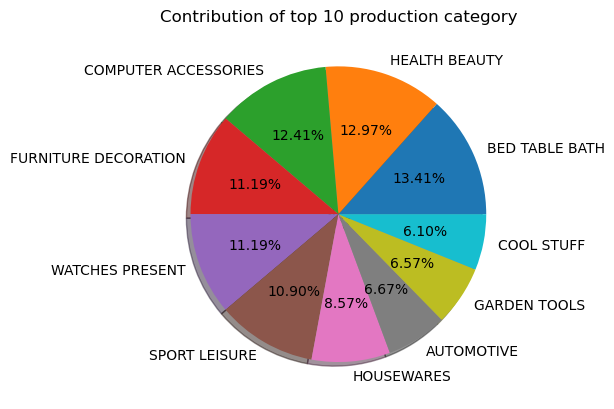

In [61]:
# visualization 
plt.pie(df.Sales[0:10], labels = df.Product_category[0:10],shadow = True, autopct = '%0.2f%%')
plt.title('Contribution of top 10 production category')
plt.show()


### *Identify the correlation between product price and the number of times a product has been purchased.*

In [62]:
query = ''' SELECT `Product category`, COUNT(ot.Product_id), AVG(price)
            FROM order_items ot JOIN products p 
            ON ot.product_id = P.product_id
            GROUP BY `Product category`; '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Product_category', 'Number of times purchased', 'Average Price'])
df.head()


,Product_category,Number of times purchased,Average Price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14


In [63]:

correlation = df[['Number of times purchased', 'Average Price']].corr()
print('The correlation between product price and the number of times a product has been purchased: \n', correlation)


The correlation between product price and the number of times a product has been purchased: 
                            Number of times purchased  Average Price
Number of times purchased                       1.00          -0.11
Average Price                                  -0.11           1.00


In [64]:
query = ''' SELECT product_id, COUNT(Product_id), AVG(price)
            FROM order_items ot 
            GROUP BY product_id;  '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Product_ID', 'Number of times purchased', 'Average Price'])
df


,Product_ID,Number of times purchased,Average Price
0,4244733e06e7ecb4970a6e2683c13e61,9,59.23
1,e5f2d52b802189ee658865ca93d83a8f,1,239.90
2,c777355d18b72b67abbeef9df44fd0fd,3,199.00
3,7634da152a4610f1595efa32f14722fc,2,12.99
4,ac6c3623068f30de03045865e4e10089,12,202.40
...,...,...,...
32946,4cc4d02efc8f249c13355147fb44e34d,1,129.90
32947,b10ecf8e33aaaea419a9fa860ea80fb5,1,99.00
32948,dd469c03ad67e201bc2179ef077dcd48,1,736.00
32949,bbe7651fef80287a816ead73f065fc4b,1,229.90


In [65]:
correlation = df[['Number of times purchased', 'Average Price']].corr()
print('The correlation between product price and the number of times a product has been purchased: \n', correlation)


The correlation between product price and the number of times a product has been purchased: 
                            Number of times purchased  Average Price
Number of times purchased                       1.00          -0.03
Average Price                                  -0.03           1.00


### *Calculate the total revenue generated by each seller, and rank them by revenue.*

In [66]:
query = ''' SELECT seller_id, SUM(payment_value),
            DENSE_RANK() OVER(ORDER BY SUM(payment_value) DESC) AS Rnk
            FROM order_items ot JOIN payments pm
            ON ot.order_id = pm.order_id
            GROUP BY 1;;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ['Seller_ID', 'Total Revenue', 'Rank'])
df


,Seller_ID,Total Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3079
3091,702835e4b785b67a084280efca355756,18.56,3080
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3081
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3082


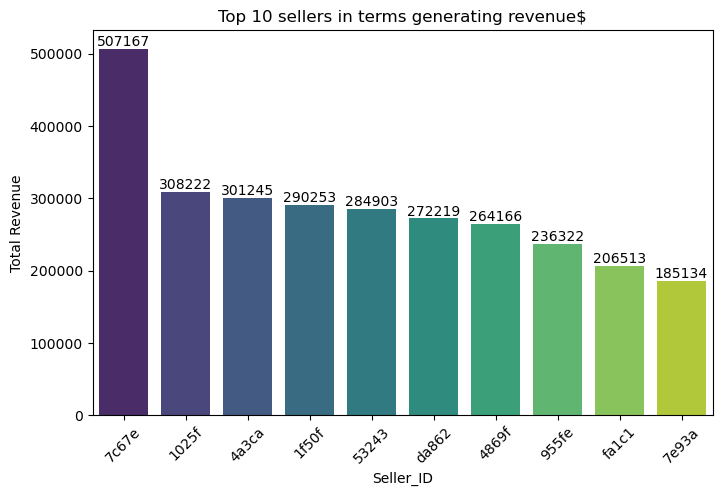

In [67]:
# visualization 
df = df.head(10)
plt.figure(figsize = (8,5))
ax = sns.barplot(x = df['Seller_ID'].str[:5], y = 'Total Revenue', data = df, palette = 'viridis')
plt.title('Top 10 sellers in terms generating revenue$')
plt.xticks(rotation = 45)
for container in ax.containers:
    ax.bar_label(container)
plt.show()


### *Calculate the moving average of order values for each customer over their order history.*

In [68]:
query = ''' SELECT customer_id, order_purchase_timestamp, payment_value, 
            AVG(payment_value) OVER (
            	PARTITION BY customer_id 
            	ORDER BY order_purchase_timestamp 
            	ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
                ) AS moving_avg
FROM orders o JOIN payments p
ON p.order_id = o.order_id;'''

cur.execute(query)

data = cur.fetchall()
pd.DataFrame(data, columns = ['Customer_ID', "Order Date", "Payment", "Moving_Average"])


,Customer_ID,Order Date,Payment,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


### *Calculate the cumulative sales per month for each year.*

In [69]:
query = '''WITH CTE AS (
            SELECT YEAR(order_purchase_timestamp) AS year_, MONTH(order_purchase_timestamp) as mnth, 
            ROUND(SUM(payment_value), 2)  as payment
            FROM Orders o JOIN payments p
            ON o.order_id = p.order_id
            GROUP BY 1, 2) 
            SELECT *, SUM(payment) OVER (ORDER BY year_, mnth) as cummulative_sum
            FROM CTE;'''

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Year', 'Month', 'Payment', 'Cumulative_Sales'])
df


,Year,Month,Payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### *Calculate the year-over-year growth rate of total sales.*

In [70]:
query = ''' WITH CTE AS (
            SELECT YEAR(order_purchase_timestamp) AS year_,
            ROUND(SUM(payment_value), 2)  as payment
            FROM Orders o JOIN payments p
            ON o.order_id = p.order_id
            GROUP BY 1
            ORDER BY 1 )
            SELECT year_, payment,
            LAG(Payment) OVER (ORDER BY year_) as previous_year, 
            (payment - LAG(Payment) OVER (ORDER BY year_)) / LAG(Payment) OVER (ORDER BY year_) * 100 as yoy
            FROM cte;'''

cur.execute(query)
data = cur.fetchall()
pd.DataFrame(data, columns = ['Year', 'Payment', 'Previous Year', "Year-Over-Year Growth Rate"])


,Year,Payment,Previous Year,Year-Over-Year Growth Rate
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.70
2,2018,8699763.05,7249746.73,20.00


### *Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.*

In [71]:
query = ''' WITH first_ord as(
            SELECT customer_id, MIN(Order_purchase_timestamp) AS First_order
            FROM orders
            GROUP BY 1),
            counted as (
            SELECT o.customer_id, COUNT(DISTINCT order_id) as Next_order
            FROM first_ord JOIN orders o
            ON first_ord.customer_id = o.customer_id
            AND order_purchase_timestamp > First_order
            AND order_purchase_timestamp < DATE_ADD(First_order, INTERVAL 6 MONTH)
            GROUP BY 1)
            SELECT (COUNT(c.customer_id) / COUNT(f.customer_id)) * 100
            FROM first_ord f LEFT JOIN counted c
            ON f.customer_id = c.customer_id;'''

cur.execute(query)
data = cur.fetchall()
print(f'Customer retention rate is : {data[0][0]}%')


Customer retention rate is : 0.0000%


### *Identify the top 3 customers who spent the most money in each year.*

In [72]:
query = ''' WITH cte AS(
            SELECT customer_id, YEAR(order_purchase_timestamp) AS year_, SUM(payment_value) AS total
            FROM orders o JOIN payments p
            ON o.order_id = p.order_id
            GROUP BY 1, 2),
            top AS(
            SELECT *, DENSE_RANK()OVER (PARTITION BY year_ ORDER BY total DESC) AS rnk
            FROM cte)
            SELECT customer_id, year_, total, rnk
            FROM top
            WHERE rnk < 4
            ;'''

cur.execute(query)
data = cur.fetchall()
pd.set_option('display.float_format', '{:.2f}'.format)
df = pd.DataFrame(data, columns = ['Customer_ID', "Year", 'Total_Spent', 'Rank'])
df


,Customer_ID,Year,Total_Spent,Rank
0,a9dc96b027d1252bbac0a9b72d837fc6,2016,1423.55,1
1,1d34ed25963d5aae4cf3d7f3a4cda173,2016,1400.74,2
2,4a06381959b6670756de02e07b83815f,2016,1227.78,3
3,1617b1357756262bfa56ab541c47bc16,2017,13664.08,1
4,c6e2731c5b391845f6800c97401a43a9,2017,6929.31,2
5,3fd6777bbce08a352fddd04e4a7cc8f6,2017,6726.66,3
6,ec5b2ba62e574342386871631fafd3fc,2018,7274.88,1
7,f48d464a0baaea338cb25f816991ab1f,2018,6922.21,2
8,e0a2412720e9ea4f26c1ac985f6a7358,2018,4809.44,3


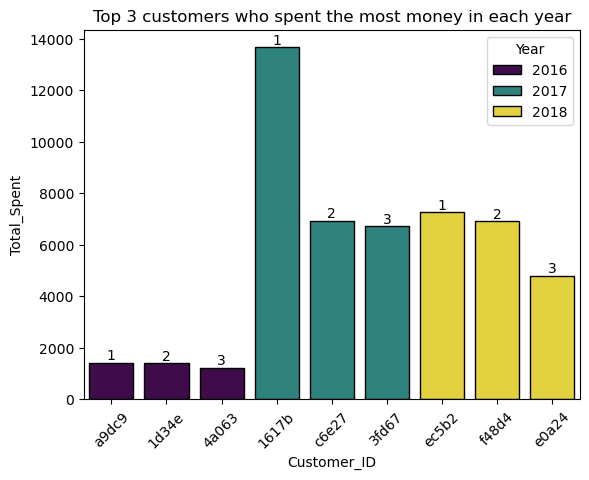

In [73]:
#visualization
ax = sns.barplot(x = df.Customer_ID.str[:5], y =df.Total_Spent, hue = df.Year, palette = 'viridis', edgecolor = 'black')
plt.xticks(rotation = 45)
plt.title('Top 3 customers who spent the most money in each year')

for container in ax.containers:
    # Extract the values of bars in the current container
    values = container.datavalues
    
    # Sort the bars and assign ranks within each hue group
    ranks = pd.Series(values).rank(ascending=False, method='dense').astype(int)
    
    # Attach ranks to each bar
    ax.bar_label(container, labels=[f'{rank}' for rank in ranks])
plt.show()
